# Coin Flips

Pretty much every statistical measurement problem starts with coin flips. We will do two different coin flipping models:
- Flip a single coin 100 times
- Flip a collection of 10 coins each 200 times

I do **not** use `arviz` in this notebook. This is to force showing how to extract the information we want from the MCMC chains.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline

## $\S$ 1.1: Flipping a coin 100 times

### Data generation

In [2]:
np.random.seed(42)
heads = np.random.binomial(n=100, p=0.5, size=(1,))

In [3]:
heads

array([49])

### Model

We will model the coin as having a beta binomial prior, with $\alpha = \beta = 40$

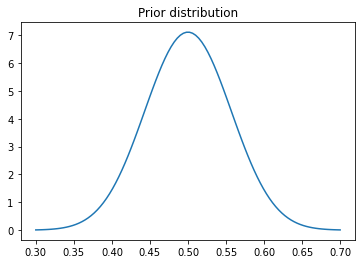

In [4]:
p_space = np.linspace(0.3, 0.7, 100)
plt.plot(p_space, beta(a=40, b=40).pdf(p_space))
plt.title('Prior distribution');

Our model is pretty simple:
```
p ~ beta(40, 40)
N ~ Binomial(100, p)
```

The beta is conjugate to the binomial distribution, so the posterior is simply ```beta(40+heads[0], 40+(100-heads[0]))```

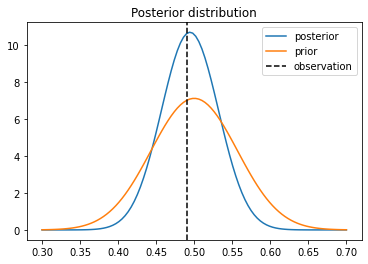

In [5]:
plt.plot(p_space, beta(a=40 + heads[0], b=40 + (100-heads[0])).pdf(p_space), label='posterior')
plt.plot(p_space, beta(a=40, b=40).pdf(p_space), label='prior')
plt.axvline(x=heads[0]/100, label='observation', c='k', ls='--')
plt.legend()
plt.title('Posterior distribution');

### Rewriting this with numpyro

In [6]:
import inspect
import math
import os
import warnings

#import arviz as az

import jax.numpy as jnp
from jax import lax, ops, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation

In [7]:
def model_single_coin_flip(heads=None):
    """Model a single coin flipped 100 times
    
    Generates p once, then the binomial from 100 trials. Numpyro aslo has a betabinomial
    that will allow you to do both in one step.
    """
    p = numpyro.sample("fairness", dist.Beta(40, 40))
    return numpyro.sample("heads", dist.Binomial(total_count=100, probs=p), obs=heads)

In [8]:
chain_run = MCMC(NUTS(model_single_coin_flip), num_warmup=500, num_samples=2500, num_chains=1)

In [9]:
heads

array([49])

In [10]:
chain_run.run(random.PRNGKey(0), heads=heads)

sample: 100%|██████████| 3000/3000 [00:05<00:00, 567.45it/s, 1 steps of size 1.07e+00. acc. prob=0.89]


In [11]:
chain_run.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  fairness      0.49      0.04      0.49      0.44      0.56    780.48      1.00

Number of divergences: 0


Let's show the sample distribution of the `fairness` parameter. We are looking for the "Hairy Catapiller" where lack of flat regions tell us that the posterior was being sampled efficiently.

Notice that the first 500 samples (the warmup / burn-in) do not appear here.

Text(0, 0.5, 'Fairness in sample')

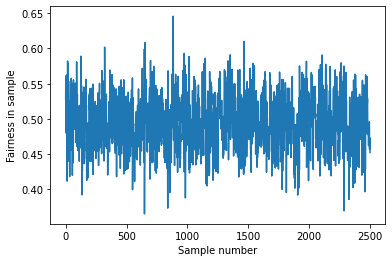

In [12]:
plt.plot(chain_run.get_samples()['fairness'])
plt.xlabel('Sample number')
plt.ylabel('Fairness in sample')

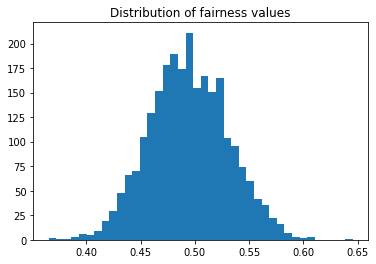

In [13]:
plt.hist(chain_run.get_samples()['fairness'], bins=40)
plt.title('Distribution of fairness values');

Let's compare this to the posterior:

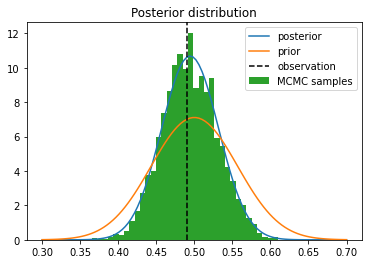

In [14]:
plt.plot(p_space, beta(a=40 + heads[0], b=40 + (100-heads[0])).pdf(p_space), label='posterior')
plt.plot(p_space, beta(a=40, b=40).pdf(p_space), label='prior')
plt.axvline(x=heads[0]/100, label='observation', c='k', ls='--')
plt.hist(chain_run.get_samples()['fairness'], bins=40, density=True, label='MCMC samples');
plt.legend()
plt.title('Posterior distribution');

We see that the MCMC chain makes a reasonable approximation of the analytic answer using the beta binomial approach, so this inspires confidence.

We can also show the confidence interval from the samples directly:

In [15]:
np.quantile(chain_run.get_samples()['fairness'], [0.05, 0.95])

array([0.43623226, 0.55499141])

## $\S$ 1.2: Many coins -- naive

### Data generation

These are the true probability of flipping a head per coin:

In [16]:
np.random.seed(42)
ALPHA, BETA = 90, 90
multiple_p = beta.rvs(ALPHA, BETA, size=(100))

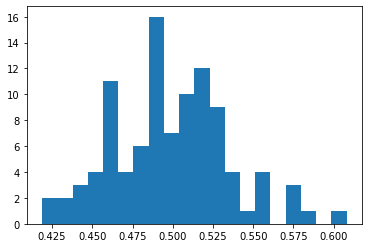

In [17]:
plt.hist(multiple_p, bins=20);

Now let's generate some random data (200 flips per coin)

In [18]:
heads = np.random.binomial(n=200, p=multiple_p)

In [19]:
def multi_coin_model_specify_coin(coin_num, heads):
    n_coins = len(heads)
    p_coins = numpyro.sample("fairness", dist.Beta(40, 40), sample_shape=(n_coins,))
    p_this_coin = p_coins[coin_num]
    return numpyro.sample("heads", dist.Binomial(200, p_this_coin), obs=flips)

In [20]:
chain_run_100_naive = MCMC(NUTS(multi_coin_model_specify_coin), num_warmup=500, num_samples=2500, num_chains=1)

In [21]:
chain_run_100_naive.run(random.PRNGKey(0), coin_num=np.arange(0,100), heads=heads)

NameError: name 'flips' is not defined

In [ ]:
chain_run_100_naive.print_summary()

In [ ]:
# compare the actual values with the true values
estimates = chain_run_100_naive.get_samples()['fairness'].mean(axis=0)
low, high = 0, 20
plt.plot(estimates[low:high], label='estimates')
plt.plot(multiple_p[low:high], label='true values')
plt.plot(heads[low:high]/200, 'o', label='raw exp results')
plt.legend()

### $\S$ 1.3: Multiple coins, but using "plates"

Let's use the same generated data, but this time use the plate technique we see in the documentation (e.g. [here](http://num.pyro.ai/en/stable/examples/baseball.html))

In [ ]:
def multi_coin_model_specify_coin_plate(heads):
    """Using plates to flip multiple coins. 
    
    The value p is broadcast to the different chains"""
    n_coins = len(heads)
    with numpyro.plate('num_coins', n_coins):
        p = numpyro.sample("fairness", dist.Beta(40, 40))
        return numpyro.sample("heads", dist.Binomial(200, p), obs=heads)

In [ ]:
chain_run_100_plates = MCMC(NUTS(multi_coin_model_specify_coin_plate), num_warmup=500, num_samples=2500, num_chains=1)

In [ ]:
chain_run_100_plates.run(random.PRNGKey(0), heads=heads)

In [ ]:
chain_run_100_plates.print_summary()

## $\S$1.4: One more model

Let's try pooling information from our coins to estimate the parameters of the coin distribution. That is, we will have

```
alpha ~ Exponential(60)
beta ~ Exponential(60)
p[i] ~ Beta(alpha, beta)
heads[i] ~ Binomial(200, p[i]) 
```

In [ ]:
def hyperparam_coin_model(heads=None):
    """Using plates to flip multiple coins. 
    
    The value p is broadcast to the different chains"""
    n_coins = len(heads)
    alpha = numpyro.sample("alpha", dist.Exponential(0.01))
    beta = numpyro.sample("beta", dist.Exponential(0.01))
    
    with numpyro.plate('num_coins', n_coins):
        p = numpyro.sample("fairness", dist.Beta(alpha, beta))
        return numpyro.sample("heads", dist.Binomial(200, p), obs=heads)

In [ ]:
chain_run_hyper = MCMC(NUTS(hyperparam_coin_model), num_warmup=500, num_samples=2500, num_chains=1)

In [ ]:
chain_run_hyper.run(random.PRNGKey(0), heads=heads)

In [ ]:
chain_run_hyper.print_summary()

In [ ]:
plt.hist(chain_run_hyper.get_samples()['alpha'], bins=30);

We see the priors are not particularly well constrained, but that this specification does the "right thing" and only produces two priors that are pooled across the sample.

## $\S$ 1.5: Seeing new coins

Let's say we have 10 more coins, produced by the same factory or process (i.e. they have same True prior, not the prior found before). 

In [ ]:
new_p = beta(a=ALPHA, b=BETA).rvs(size=10)

In [ ]:
new_p

In [ ]:
new_data = np.random.binomial(200, new_p)

In [ ]:
new_data

In [ ]:
rng_key

In [ ]:
rng_key_predict = random.PRNGKey(30)

In [ ]:
try:
    predictions = Predictive(hyperparam_coin_model, posterior_samples=chain_run_hyper.get_samples())(rng_key_predict, new_data)
except ValueError as e:
    print(e)

Our existing model has no way of knowing how many things to predict (we have no featurse). Let's make it look like the baseball example instead by adding the number of coins

In [ ]:
def hyperparam_coin_model_two(n_coins, heads=None):
    """Using plates to flip multiple coins. 
    
    The value p is broadcast to the different chains"""
    assert (flips is None) or (n_coins == len(flips))
    alpha = numpyro.sample("alpha", dist.Exponential(0.01))
    beta = numpyro.sample("beta", dist.Exponential(0.01))
    
    with numpyro.plate('num_coins', n_coins):
        p = numpyro.sample("fairness", dist.Beta(alpha, beta))
        print(f'size of p: {len(p)}')
        return numpyro.sample("heads", dist.Binomial(200, p), obs=heads)

In [ ]:
chain_run_hyper = MCMC(NUTS(hyperparam_coin_model_two), num_warmup=500, num_samples=2500, num_chains=1)

In [ ]:
chain_run_hyper.run(random.PRNGKey(0), n_coins=100, heads=heads)

In [ ]:
predictive_model = Predictive(hyperparam_coin_model_two, posterior_samples=chain_run_hyper.get_samples())

In [ ]:
predictive_model(rng_key_predict, n_coins=100)